In [1]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML

In [2]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, is_res: bool = False) -> None:
        super().__init__()
        self.same_channels = in_channels == out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(8, out_channels), 
            nn.ReLU(), 
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            out = x1 + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

In [3]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels), 
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        return self.model(torch.cat((x, skip), 1))


In [4]:

class EmbedFC(nn.Module):
    def __init__(self, input_dim , emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim).to(device)
        return self.model(x)

In [5]:
class TimeSiren(nn.Module):
    def __init__(self, emb_dim):
        super(TimeSiren, self).__init__()

        self.lin1 = nn.Linear(1, emb_dim, bias=False)
        self.lin2 = nn.Linear(emb_dim, emb_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, 1).to(device)
        x = torch.sin(self.lin1(x))
        x = self.lin2(x)
        return x

In [6]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10):
        super(ContextUnet, self).__init__()
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.down3 = UnetDown(2*n_feat, 2 * n_feat) 
        
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.ReLU())
        
        self.timeembed1 = TimeSiren(2*n_feat)
        #self.timeembed2 = TimeSiren(1*n_feat)
        
        #self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        #self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)
        
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 4, 4), 
            nn.GroupNorm(8, 2 * n_feat),                        
            nn.ReLU(),
        )
        
        self.up1 = UnetUp(4 * n_feat, 2*n_feat)
        self.up2 = UnetUp(4 * n_feat, n_feat)
        self.up3 = UnetUp(2*n_feat, n_feat)
        self.out = nn.Conv2d(2 * n_feat, self.in_channels, 3, 1, 1)

    def forward(self, x, t, c=None):
        x = self.init_conv(x)
        
        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        
        hiddenvec = self.to_vec(down3)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        #if c is None:
        #   c = torch.zeros(x.shape[0], self.n_cfeat).to(x)
        #cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        #cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        #temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        up0 = self.up0(hiddenvec + temb1)
        up1 = self.up1(up0, down3) + temb1
        up2 = self.up2(up1, down2)
        up3 = self.up3(up2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out


In [7]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.0

In [33]:
timesteps = 1000
beta1 = 1e-4
beta2 = 0.02


device="cuda" if torch.cuda.is_available() else "gpu"
n_feat = 256
n_cfeat = 10 
height = 32 
save_dir = './weight_cifar/'

batch_size = 256
n_epoch = 1000
lrate=1e-5

In [9]:
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat).to(device)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

In [10]:
from torchvision.datasets import CIFAR10
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = CIFAR10("./data", train=True, download=True, transform=tf)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=16)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

Files already downloaded and verified


In [11]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.18241689600000002

In [12]:
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1) + beta1
sqrt_b_t = torch.sqrt(b_t)
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()  
sqrt_ab_t = torch.sqrt(ab_t)
oneover_sqrt_a_t = 1/torch.sqrt(a_t)
sqrt_mab = torch.sqrt(1 - ab_t)
mab_over_sqrtmab_inv = (1 - a_t) / sqrt_mab

b_t = b_t.to(device)
a_t  = a_t.to(b_t)
ab_t = ab_t.to(a_t)


In [13]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.18242918400000002

In [14]:
@torch.no_grad()
def sample_ddpm_context(n_sample, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    
    for i in range(timesteps, 0, -1):
        # reshape time tensor
        #t = torch.tensor([i / timesteps])[:, None, None, None].to(device)
        t = torch.tensor(i / timesteps).to(device).repeat(n_sample, 1)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t)    # predict noise e_(x_t,t, ctx)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [15]:
# helper function: perturbs an image to a specified noise level
def perturb_input(x, t, noise, device=device):
    final = ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise
    final = final.to(device)
    return final

In [16]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [17]:
# define sampling function for DDIM   
# removes the noise using ddim
def denoise_ddim(x, t, t_prev, pred_noise):
    ab = ab_t[t]
    ab_prev = ab_t[t_prev]
    
    x0_pred = ab_prev.sqrt() / ab.sqrt() * (x - (1 - ab).sqrt() * pred_noise)
    dir_xt = (1 - ab_prev).sqrt() * pred_noise

    return x0_pred + dir_xt

In [18]:
# fast sampling algorithm with context
@torch.no_grad()
def sample_ddim_context(n_sample, n=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    step_size = timesteps // n
    for i in range(timesteps, 0, -step_size):
        
        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        eps = nn_model(samples, t)    # predict noise e_(x_t,t)
        samples = denoise_ddim(samples, i, i - step_size, eps)
        intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [19]:
def make_encoding(x, n_samples=batch_size, n_classes=n_cfeat):
    encode = [
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
    ]
    final = np.zeros((n_samples, n_classes))
    for i in range(n_samples):
        final[i] = encode[x[i].int()]
    final = torch.tensor(final).float().to(device)
    return final

In [20]:
loss_train  = []
loss_values_1 = []

In [75]:
def show_images(imgs, nrow=4):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img, cmap='gray')
    plt.show()

In [22]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9


0.18242918400000002

In [23]:
import gc
torch.cuda.empty_cache()
gc.collect()

124

In [68]:
checkpoint = torch.load(f"{save_dir}nn_model260.pth", map_location = device)
epoch = checkpoint['epoch']
optim.load_state_dict(checkpoint['optimizer_state_dict'])
nn_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [71]:
import os
nn_model.train()


for ep in range(epoch, n_epoch):
    print("allocated mem -", torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9)
    print("epoch number: ", ep)
    optim.param_groups[0]['lr'] = lrate
    pbar = tqdm(dataloader, mininterval = 2)
    #print(pbar)
    #break
    #k=0
    loss_val = 0
    for x,_ in pbar:
        optim.zero_grad()
        x=x.to(device)
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],))
        x_pert = perturb_input(x, t, noise).to(device)
        pred_noise = nn_model(x_pert, t/timesteps)
        loss = F.mse_loss(pred_noise, noise)
        #loss_values_1.append(loss.item())
        loss_val+=loss
        loss.backward()
        optim.step()
    if(ep%10==0):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save({
            'epoch': ep,
            'model_state_dict': nn_model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss_val
            }, str(save_dir+f"nn_model{ep}.pth"))
        print("Saved model at " + str(save_dir+f"nn_model{ep}.pth"))
    print(loss_val)
    

allocated mem - 1.3242234880000001
epoch number:  200


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


Saved model at ./weight_cifar/nn_model200.pth
tensor(13.9127, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  201


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(14.1683, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  202


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.53it/s]


tensor(13.9087, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  203


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(14.1970, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  204


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.9822, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  205


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(14.1856, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  206


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.8453, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  207


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.9288, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  208


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.9111, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  209


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.9245, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  210


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


Saved model at ./weight_cifar/nn_model210.pth
tensor(13.8434, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  211


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(14.2462, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  212


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.53it/s]


tensor(13.9224, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  213


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.9853, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  214


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(14.0921, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  215


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(14.0598, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  216


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.8121, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  217


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.9405, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  218


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.53it/s]


tensor(13.9877, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  219


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.8624, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  220


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


Saved model at ./weight_cifar/nn_model220.pth
tensor(13.9615, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  221


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(14.0093, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  222


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.9017, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  223


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(14.1640, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  224


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.53it/s]


tensor(14.1535, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  225


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.8916, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  226


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.9724, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  227


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.7875, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  228


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.6835, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  229


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.7625, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  230


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.53it/s]


Saved model at ./weight_cifar/nn_model230.pth
tensor(14.0841, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  231


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.6007, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  232


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.6971, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  233


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.53it/s]


tensor(13.9302, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  234


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.8708, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  235


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.8548, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  236


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(14.0532, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  237


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(14.0202, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  238


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.8750, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  239


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.9511, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  240


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


Saved model at ./weight_cifar/nn_model240.pth
tensor(13.7021, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  241


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.6802, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  242


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.9429, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  243


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.8085, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  244


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.8900, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  245


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.6957, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  246


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.9110, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  247


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(14.0190, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  248


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.8152, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  249


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.8669, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  250


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


Saved model at ./weight_cifar/nn_model250.pth
tensor(13.9060, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  251


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.8099, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  252


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.9213, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  253


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.9982, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  254


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.9405, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  255


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.53it/s]


tensor(13.7391, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  256


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.7368, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  257


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.8456, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  258


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.7075, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  259


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.8796, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  260


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


Saved model at ./weight_cifar/nn_model260.pth
tensor(13.8195, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  261


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.5522, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  262


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.9769, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  263


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.8132, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  264


100%|█████████████████████████████████████████| 196/196 [02:07<00:00,  1.54it/s]


tensor(13.7507, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.319308288
epoch number:  265


 23%|█████████▋                                | 45/196 [00:31<01:45,  1.43it/s]


KeyboardInterrupt: 

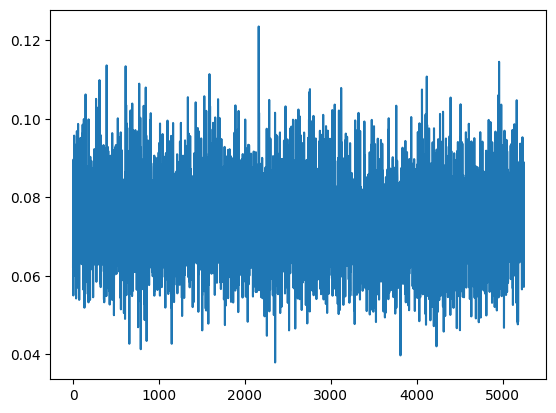

In [41]:
loss_values_1 = torch.tensor(loss_values_1).cpu()
plt.plot(np.array(loss_values_1))
loss_values_1 = loss_values_1.tolist()

In [45]:
loss_values_1

[1.0425622463226318,
 1.0202202796936035,
 0.9970542788505554,
 0.9773823618888855,
 0.9652798175811768,
 0.954014778137207,
 0.9363252520561218,
 0.9280189275741577,
 0.915996253490448,
 0.8952407240867615,
 0.8946956992149353,
 0.879905104637146,
 0.8704050779342651,
 0.8621482849121094,
 0.8509654998779297,
 0.8377400636672974,
 0.8287315368652344,
 0.8193833231925964,
 0.8089159727096558,
 0.7928543090820312,
 0.7850136756896973,
 0.7857739329338074,
 0.7731568813323975,
 0.7522597312927246,
 0.7492865920066833,
 0.7313202619552612,
 0.7357608079910278,
 0.7279250025749207,
 0.7110700011253357,
 0.7057894468307495,
 0.6850621700286865,
 0.6861337423324585,
 0.6553335189819336,
 0.6462891101837158,
 0.6443241834640503,
 0.6208381652832031,
 0.6262111067771912,
 0.6170444488525391,
 0.6068087220191956,
 0.5896410346031189,
 0.5648505687713623,
 0.562142550945282,
 0.558562159538269,
 0.5414583086967468,
 0.5365532636642456,
 0.5452604293823242,
 0.5183343887329102,
 0.516748070716857

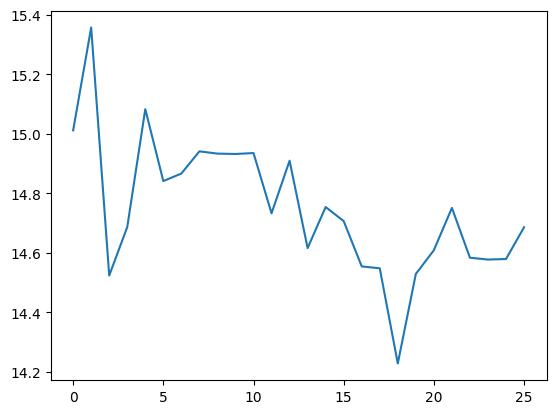

In [42]:
loss_values_1 = np.asarray(loss_values_1)
sum1=0
loss_values_epoch=[]
for i in range(1, loss_values_1.shape[0]):
    sum1+=loss_values_1[i]
    if(i%200==0):
        loss_values_epoch.append(sum1)
        sum1=0
loss_values_epoch = np.asarray(loss_values_epoch)
plt.plot(loss_values_epoch)

In [ ]:
loss_values_1.shape

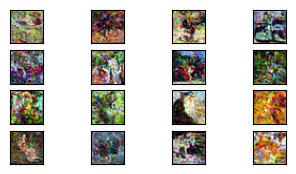

In [77]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddpm_context(16)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
import os
nn_model.train()
guide_w = 0.3
loss_values_2=[]
for ep in range(n_epoch):
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    pbar = tqdm(dataloader, mininterval = 2)
    for x, c in pbar:
        optim.zero_grad()
        x=x.to(device)
        c=c.to(device)
        c=make_encoding(c)
    #print(c.shape)
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        
    #print(c.shape)
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],))
        x_pert = perturb_input(x, t, noise).to(device)
        pred_noise_2 = nn_model(x_pert, t/timesteps, c=None)
        pred_noise_1 = nn_model(x_pert, t/timesteps, c)
        pred_noise_final = eps = (1+guide_w)*pred_noise_1 - guide_w*pred_noise_2
        loss = F.mse_loss(pred_noise_final, noise)
        loss_values_2.append(loss)
        loss.backward()
        optim.step()
    

In [ ]:
loss_values_2 = torch.tensor(loss_values_2).cpu()
plt.plot(np.array(loss_values_2)

In [ ]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddim_context(ctx.shape[0], None)
show_images(samples)

In [ ]:
# visualize samples with randomly selected context
plt.clf()
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
#animation_ddpm_context = plot_sample(intermediate,32,4,save_dir, "ani_run", None, save=False)
#HTML(animation_ddpm_context.to_jshtml())